# Analysis of Telco Churn Dataset (Done as part of Razorpay screening round)
The notebook aims to analyze the Telco churn dataset for various features and aims to use the insights gained to build a Machine Learning classifier to predict customer churn.

The notebook is further divided into the following sections:
1. Basic details about dataset
2. Univariate feature analysis
3. Bivariate feature analysis

In [269]:
import sys
import os

from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from scipy.stats import chi2_contingency

current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '../src')
sys.path.append(src_dir)

from utils import *
from config import *

## About the dataset
The dataset is taken from [Kaggle](https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset?select=Telco_customer_churn.xlsx) and is freely available.

### Context
> A fictional telco company that provided home phone and Internet services to 7043 customers in California in Q3.

### Data Description
> CustomerID: A unique ID that identifies each customer.  
> Count: A value used in reporting/dashboarding to sum up the number of customers in a filtered set.  
> Country: The country of the customer’s primary residence.  
> State: The state of the customer’s primary residence.  
> City: The city of the customer’s primary residence.  
> Zip Code: The zip code of the customer’s primary residence.  
> Lat Long: The combined latitude and longitude of the customer’s primary residence.  
> Latitude: The latitude of the customer’s primary residence.  
> Longitude: The longitude of the customer’s primary residence.  
> Gender: The customer’s gender: Male, Female  
> Senior Citizen: Indicates if the customer is 65 or older: Yes, No  
> Partner: Indicate if the customer has a partner: Yes, No  
> Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.  
> Tenure Months: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.  
> Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No  
> Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No  
> Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.  
> Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No  
> Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No  
> Device Protection: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No  
> Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No  
> Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.  
> Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.  
> Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.  
> Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No  
> Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check  
> Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.  
> Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.  
> Churn Label: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.  
> Churn Value: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.  
> Churn Score: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.  
> CLTV: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.  
> Churn Reason: A customer’s specific reason for leaving the company. Directly related to Churn Category.


In [208]:
df = read_dataframe(BASE_PATH, DATA_PATH, FILE_NAME)

In [209]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
count,7043.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
zip_code,7043.0,93521.964646,1865.794555,90001.000000,92102.000000,93552.000000,95351.000000,96161.000000
latitude,7043.0,36.282441,2.455723,32.555828,34.030915,36.391777,38.224869,41.962127
longitude,7043.0,-119.798880,2.157889,-124.301372,-121.815412,-119.730885,-118.043237,-114.192901
tenure_months,7043.0,32.371149,24.559481,0.000000,9.000000,29.000000,55.000000,72.000000
monthly_charges,7043.0,64.761692,30.090047,18.250000,35.500000,70.350000,89.850000,118.750000
churn_value,7043.0,0.265370,0.441561,0.000000,0.000000,0.000000,1.000000,1.000000
churn_score,7043.0,58.699418,21.525131,5.000000,40.000000,61.000000,75.000000,100.000000
cltv,7043.0,4400.295755,1183.057152,2003.000000,3469.000000,4527.000000,5380.500000,6500.000000


In [210]:
print(f"Number of samples = {df.shape[0]}")
print(f"Number of features = {df.shape[1]}")

Number of samples = 7043
Number of features = 33


In [211]:
num_nas = df.isna().sum(axis=0)
num_nas[num_nas > 0]

churn_reason    5174
dtype: int64

## Splitting features
Features are split into the following:
1. Categorical: features which have 6 or less unique values. We use label/one-hot encoding for these features
2. Numerical: features which have move than 6 unique values

In [212]:
df.drop(["customerid", "lat_long", "count", "country", "state", "city"], axis=1, inplace=True)
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce').dropna()
col = list(df.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(df[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)
numerical_features.remove("churn_reason")

print('Categorical Features :',categorical_features)
print('Numerical Features :',numerical_features)

Categorical Features : ['gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method', 'churn_label', 'churn_value']
Numerical Features : ['zip_code', 'latitude', 'longitude', 'tenure_months', 'monthly_charges', 'total_charges', 'churn_score', 'cltv']


### Univariate Feature Analysis
For univariate feature analysis, the features are divided into two types:
1. Categorical: For these features we plot the count of each class
2. Numeric: For these, we plot a histogram and boxplot to study the distribution and look at any outliers in the features

### Categorical Feature Analysis
In this, we try to plot the counts of each category. The feature "churn_reason" may not be useful as a feature for training ML algorithm but it can be useful for later error analysis.

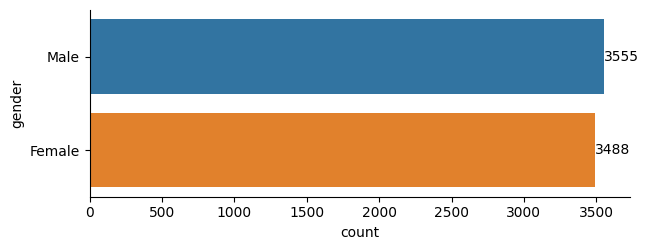

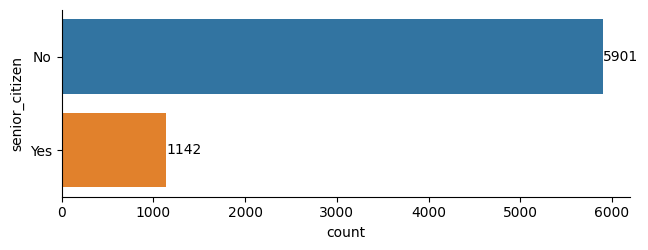

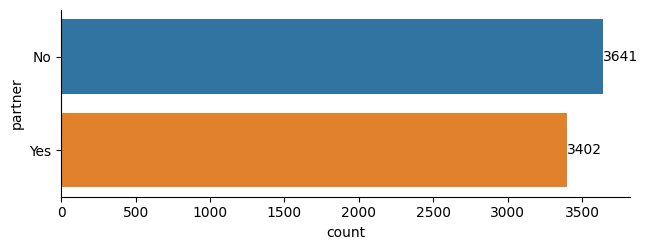

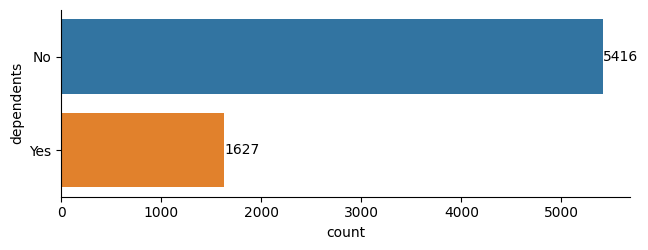

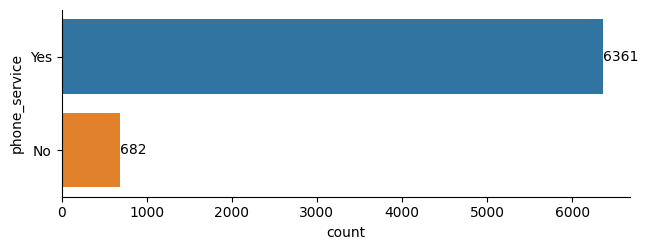

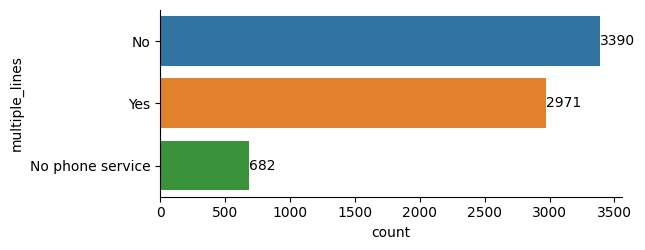

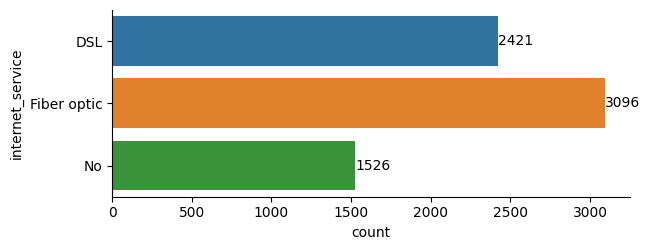

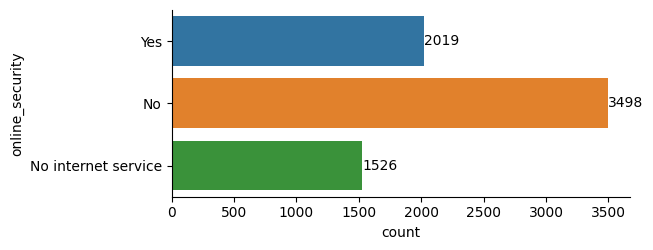

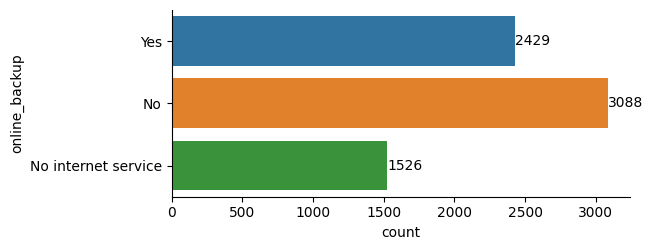

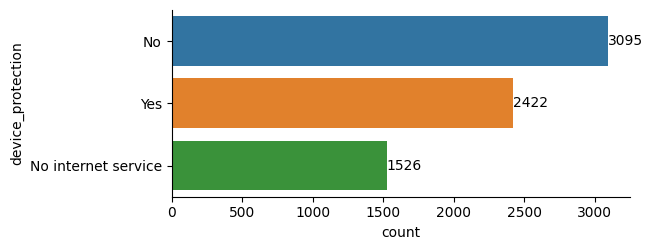

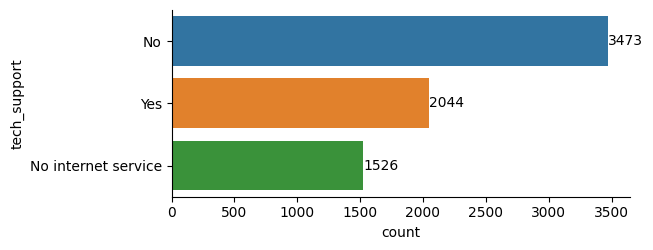

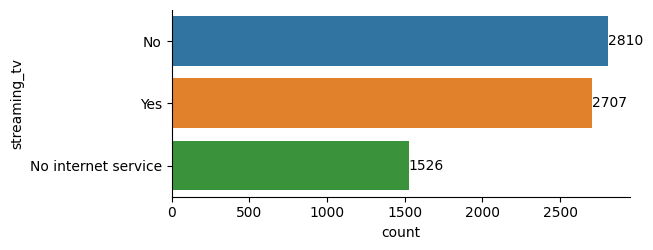

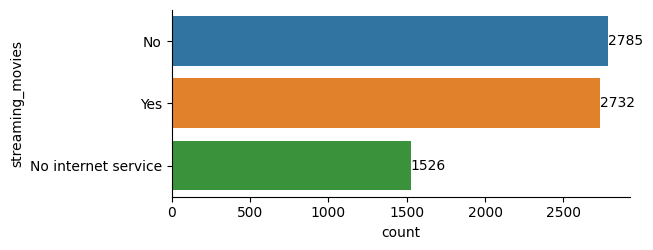

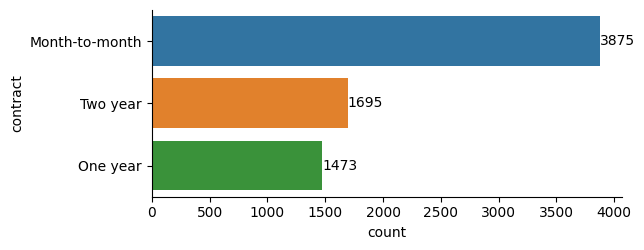

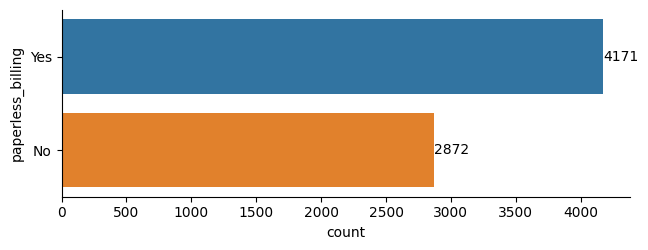

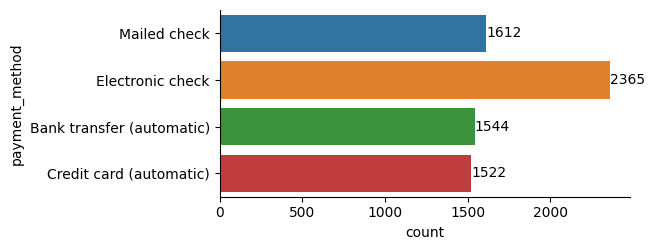

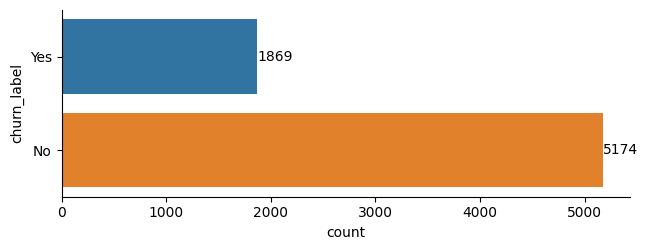

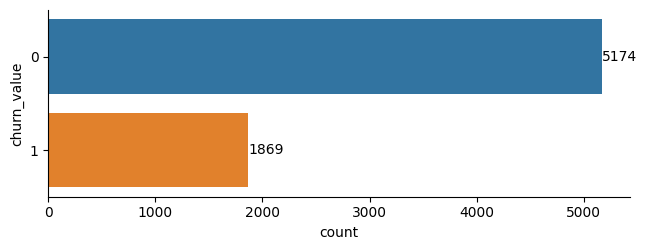

In [202]:
for f in categorical_features:
    g = sns.catplot(y=f, kind="count", data=df, height=2.6, aspect=2.5, orient='h')
    for ax in g.axes.flat:
        ax.bar_label(ax.containers[0])

### Insights from categorical features:
1. Unbalanced distribution: The target variable is not equally distributed between
2. Balanced features: The features: gender, partner are balanced, these are equally distributed between the two classes
3. Majority of the data is for non senior citizens (which may be a reflection of demographic)
4. Almost 75% of the customers in the dataset have dependents 
5. Most of the customers do not have an active phone service and not with the company
6. Most of the customers also have an internet service in some form (DSL/Fibre optic). This can be later used as a single binary feature indicating if they have an internet plan
7. Most of the subscribers have not subscribed to online security, an online backup, a device protection, tech support, or streaming tv
8. Month-to-month is the preferred model for almost 50% of clients

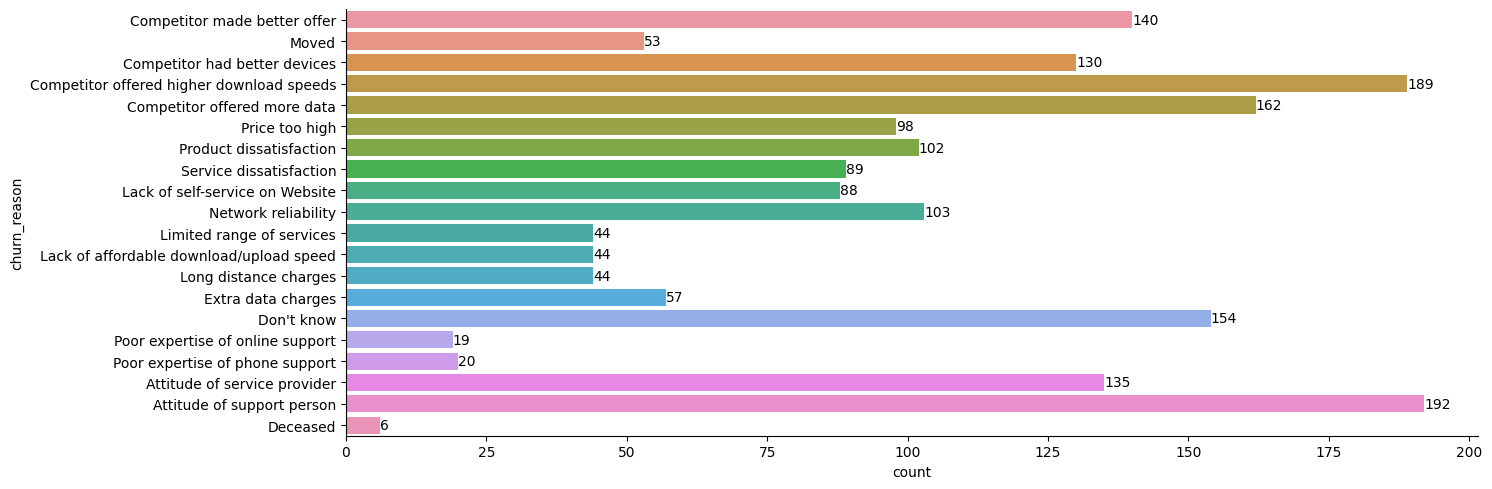

In [249]:
g = sns.catplot(y="churn_reason", kind="count", data=df, height=5, aspect=3, orient='h')
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0])

### Reasons for churn
1. External: which cannot be controlled, eg, competitior having better services
2. Internal: which can be controlled, eg, behaviour of support person
The biggest reason in this which is internal is behavious of delivery person. By pinpointing this based on zip code and lat-long, we can provide better services


### Numerical Feature Analysis
In this, we try to plot the numerical features in a histogram and a box plot. Histogram is used to see the distribution while the box plot is used to check for outliers.                                                                                                                          

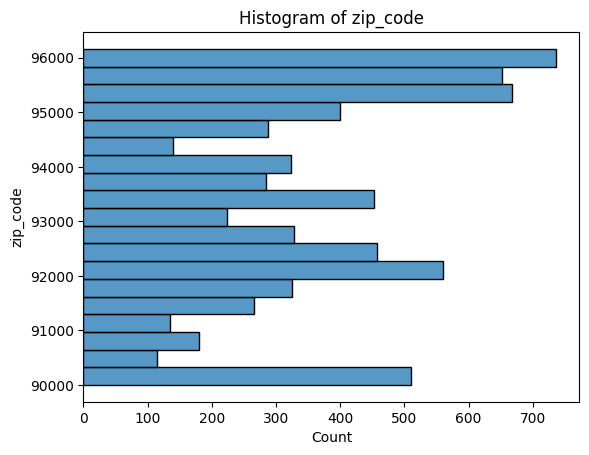

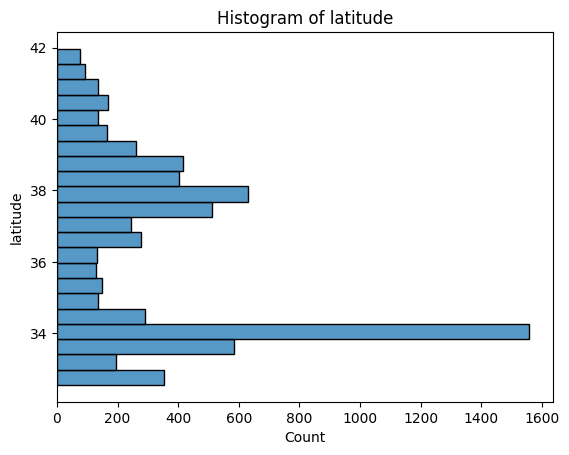

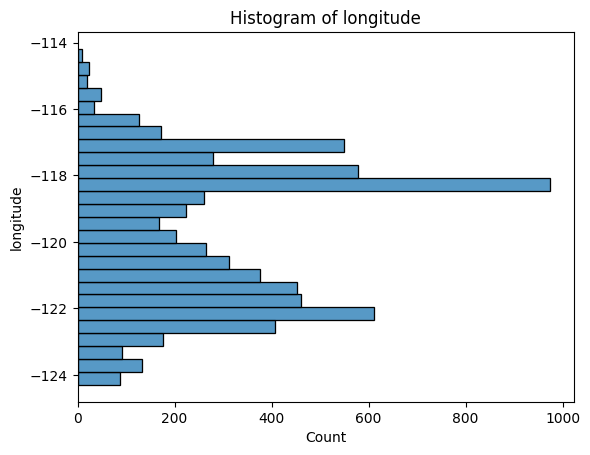

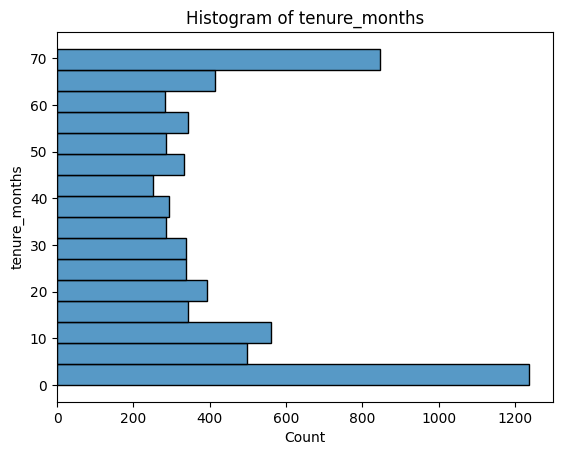

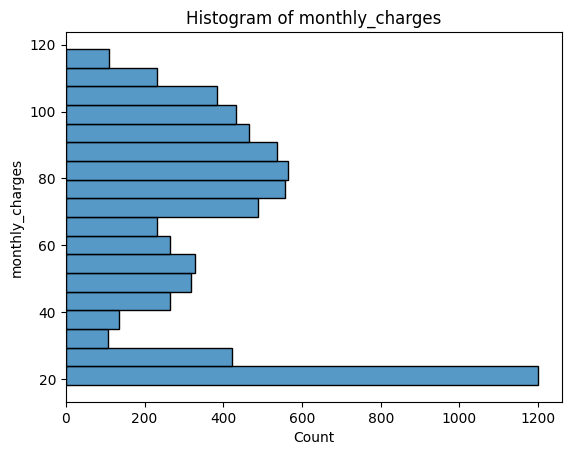

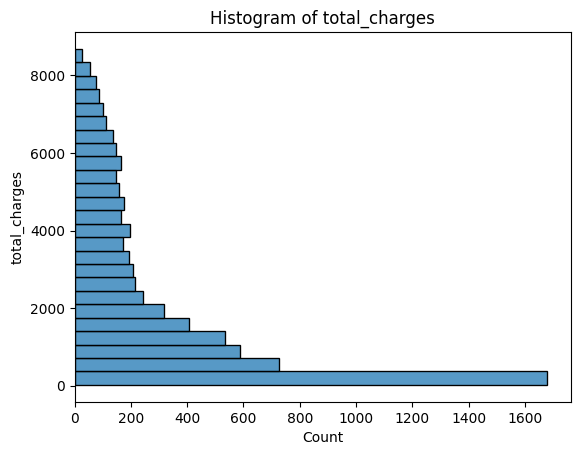

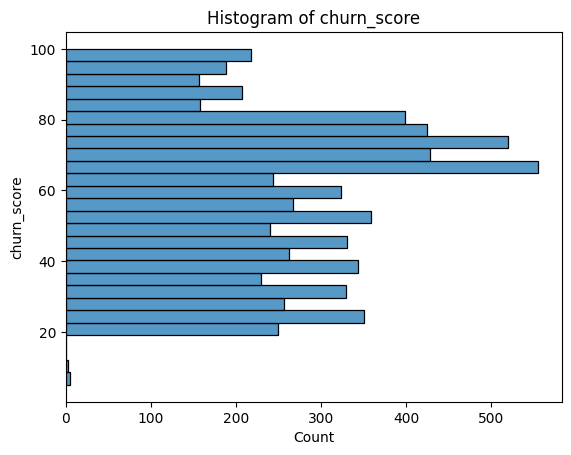

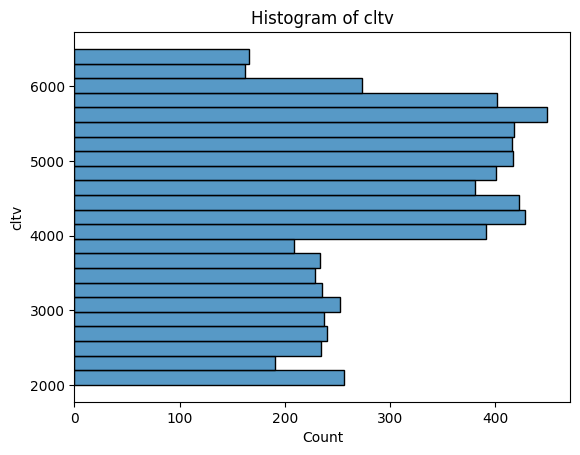

In [217]:
for f in numerical_features:
    ax = sns.histplot(y=f, data=df)
    ax.set_title(f'Histogram of {f}')
    plt.show()

### Numerical features analysis insights
1. Most common reason for churn is either competiitor offering better speeds or behaviour of staff.
2. There is a high number of customers with low tenure months indicating there have been a high number of new subscribers
3. Most customers prefer cheapest connection
4. As a result of above two, the total spending of most customers is on the lower side

## Bivariate feature analysis
In this section we try to compare the churn with other features, namely categorical and numerical. For categorical, we compare the frequency of churn values across all the classes, and for numerical we see the distibution for the feature for churned and non churned variables)

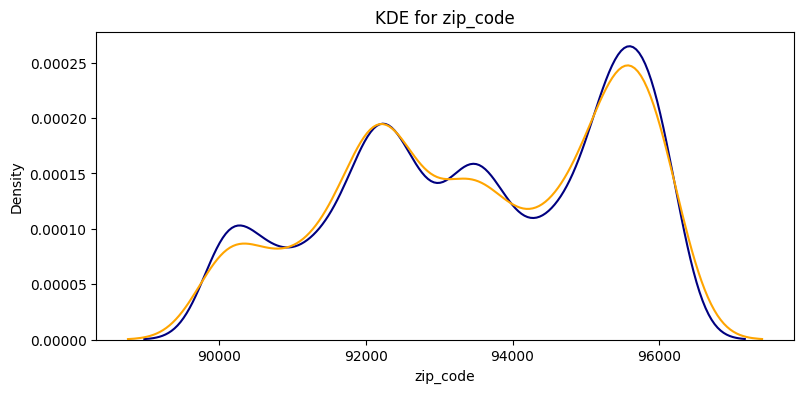

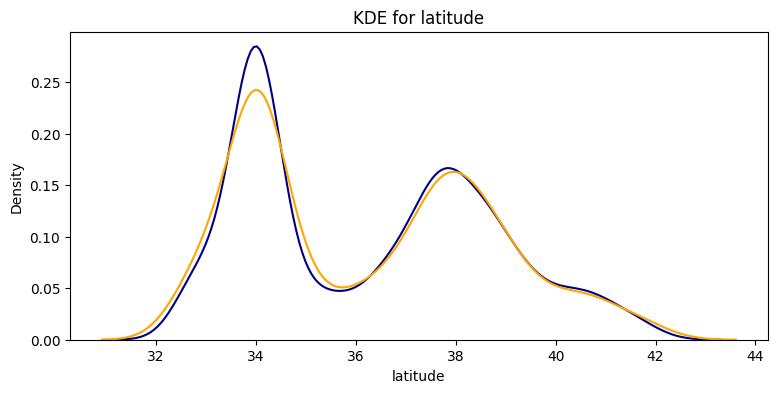

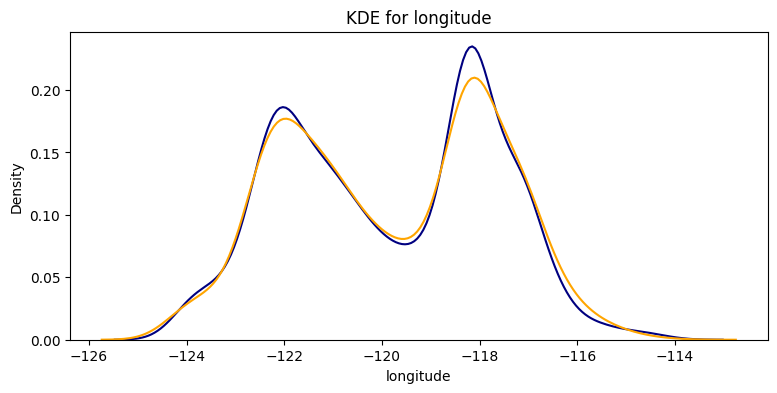

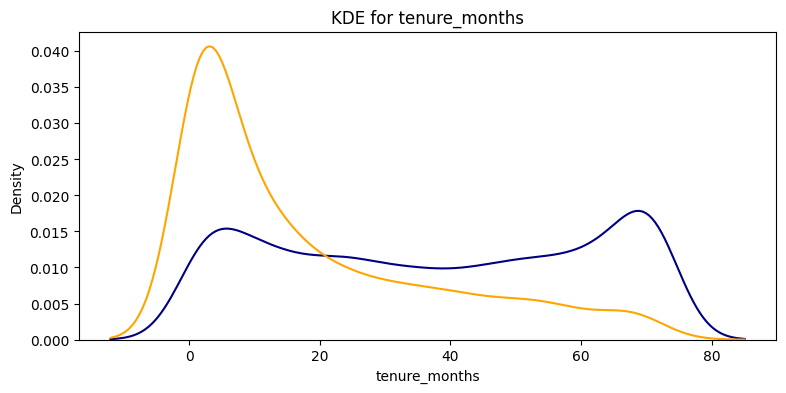

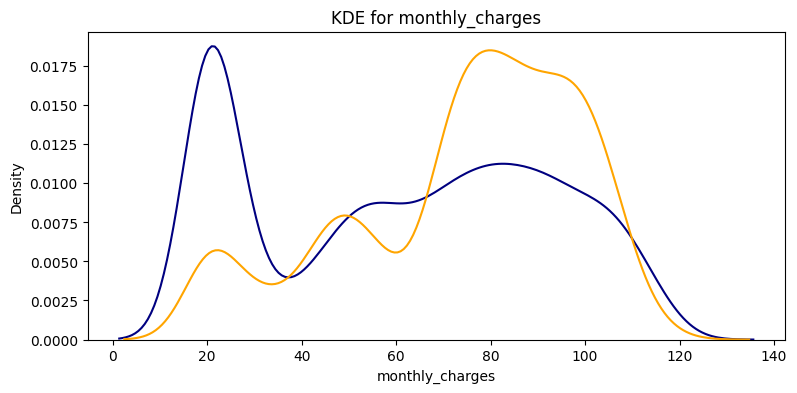

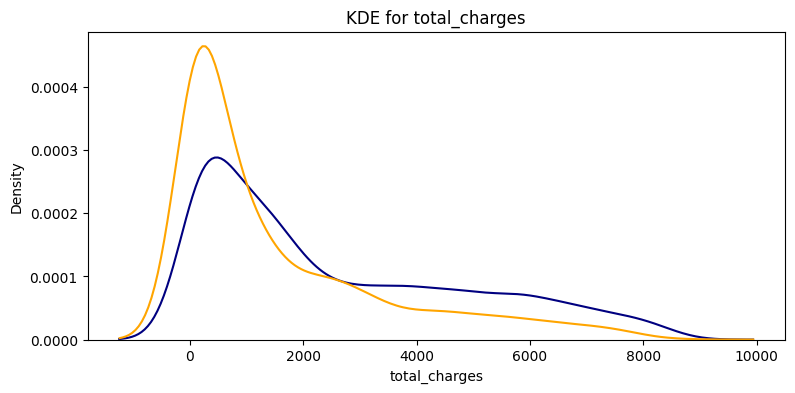

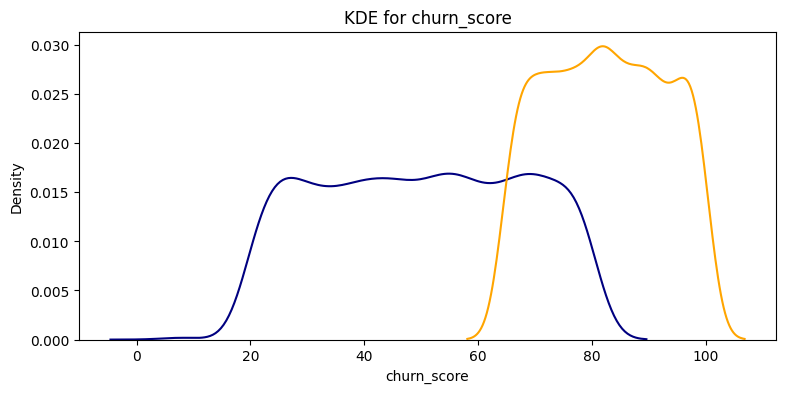

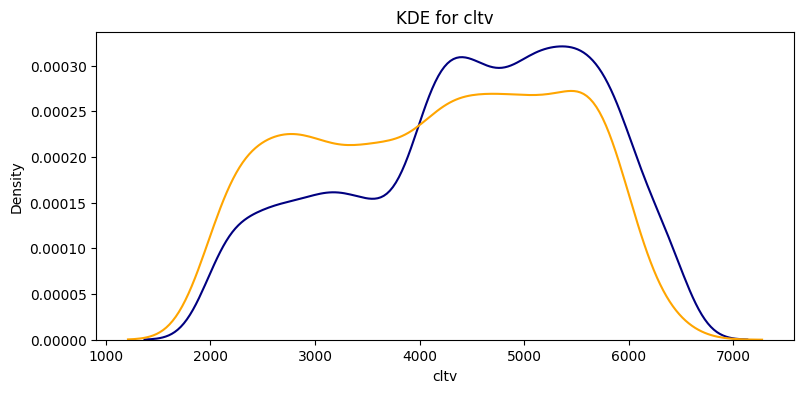

In [218]:
## dropping the empty string
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
df = df.dropna(subset=['total_charges'])

def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['churn_value'] == 0][feature].dropna().astype(float), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['churn_value'] == 1][feature].dropna().astype(float), color= 'orange', label= 'Churn: Yes')
for feature in numerical_features:
    kdeplot(feature)


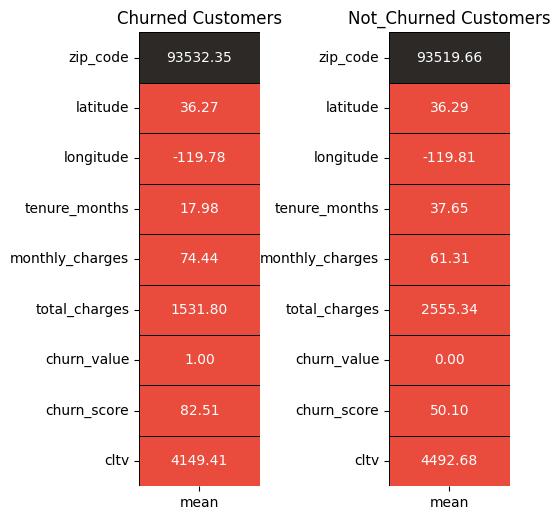

In [219]:
colors = ['#E94B3C','#2D2926']

churn = df[df['churn_value'] == 1].describe().T
not_churn = df[df['churn_value'] == 0].describe().T

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5))
plt.subplot(1,2,1)
sns.heatmap(churn[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Churned Customers');

plt.subplot(1,2,2)
sns.heatmap(not_churn[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f',)
plt.title('Not_Churned Customers');

fig.tight_layout(pad = 0)

### Insights from bivariate analysis of numerical features
1. No effect of zip code, latitude, longitude on churn implying the churn rates are not varied much by the geo-location
2. Customers with less tenure months are more likely to churn
3. churn_score is a good indicator of actual churn
4. high monthly charges imply a higher rate of churn

## Success of churn score in actual prediction
In this we try to analyze how correlated churn score as predicted by a business metric is accurate in predicting actual churn

In [235]:
score_vs_churn = pd.DataFrame()
thresholds = np.linspace(0, 100, 101)
acc = []
f1 = []
prec = []
rec = []
for t in thresholds:
    y_hat = (df["churn_score"] >= t)
    y = df["churn_value"]
    accuracy, precision, recall, f1_ = accuracy_score(y_hat, y), precision_score(y_hat, y), recall_score(y_hat, y), f1_score(y_hat, y)
    acc.append(accuracy)
    f1.append(f1_)
    prec.append(precision)
    rec.append(recall)
score_vs_churn["threshold"] = thresholds
score_vs_churn["accuracy"] = acc
score_vs_churn["f1"] = f1
score_vs_churn["precision"] = prec
score_vs_churn["recall"] = rec

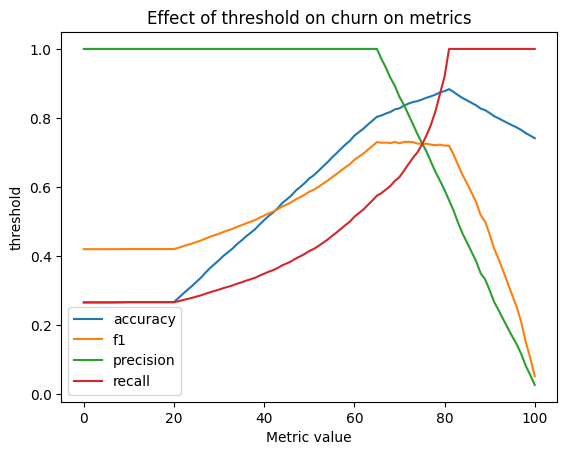

In [241]:
for metric in ["accuracy", "f1", "precision", "recall"]:
    ax = sns.lineplot(data = score_vs_churn, x = "threshold", y = metric, label = metric)
    ax.set(xlabel='Metric value', ylabel='threshold', title="Effect of threshold on churn on metrics")
    

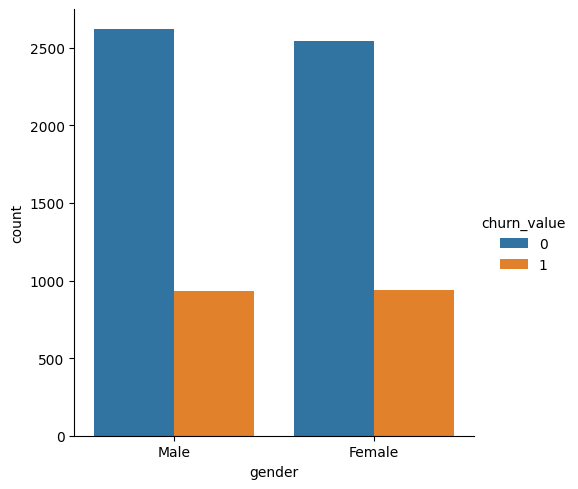

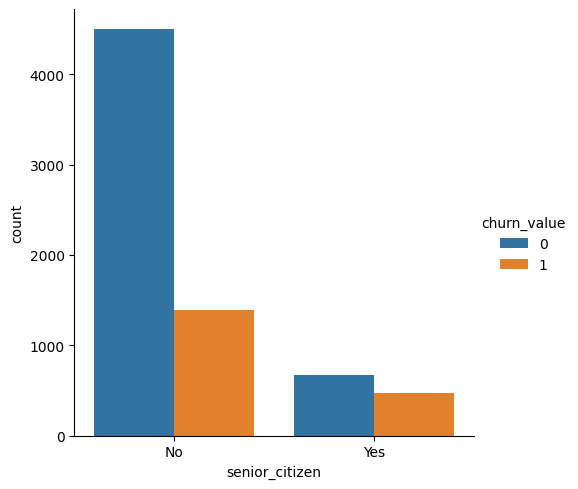

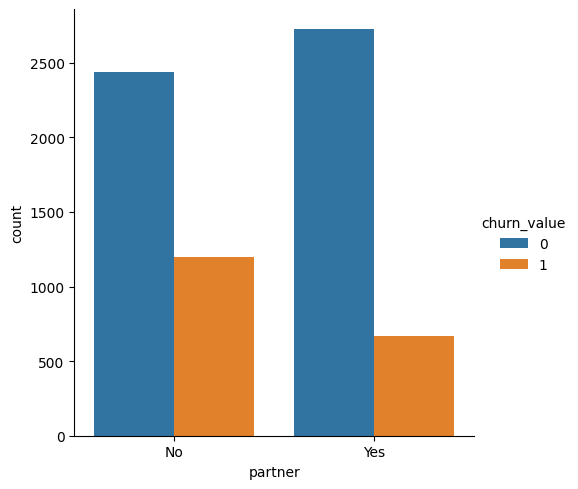

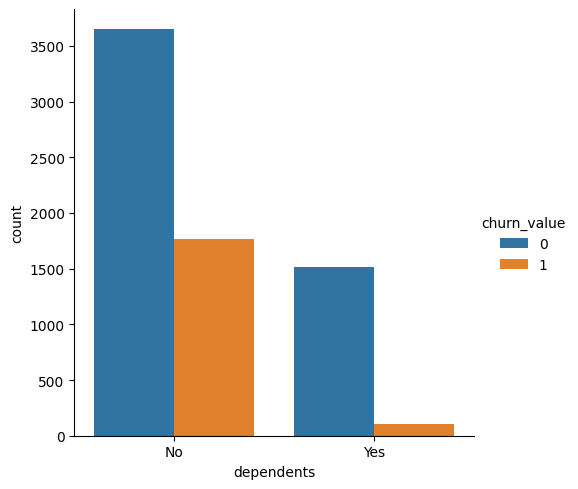

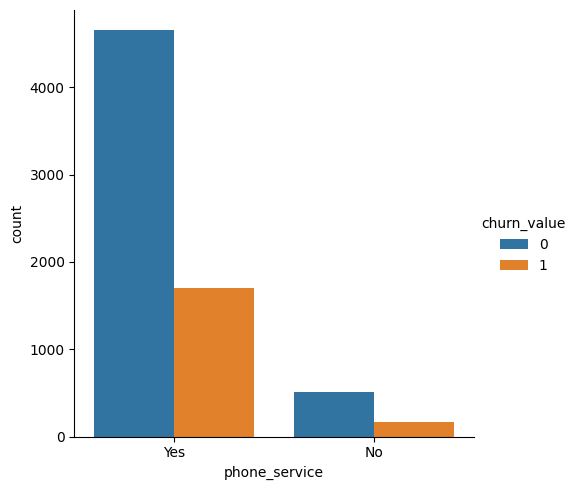

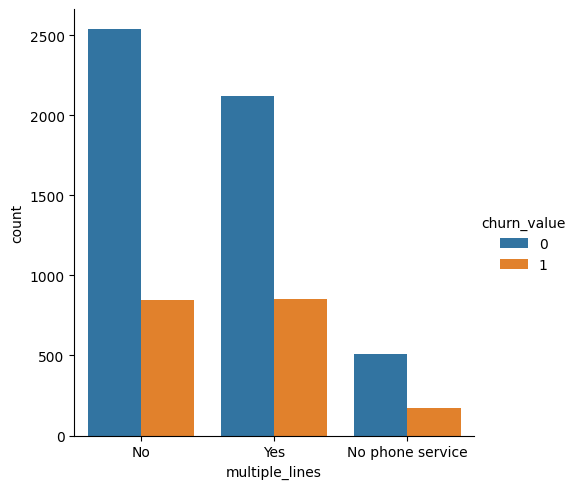

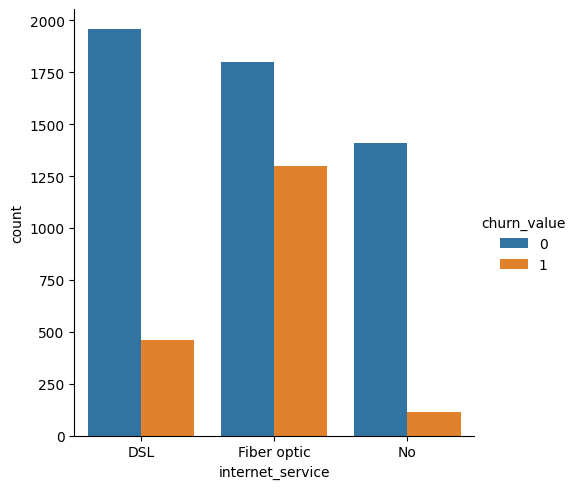

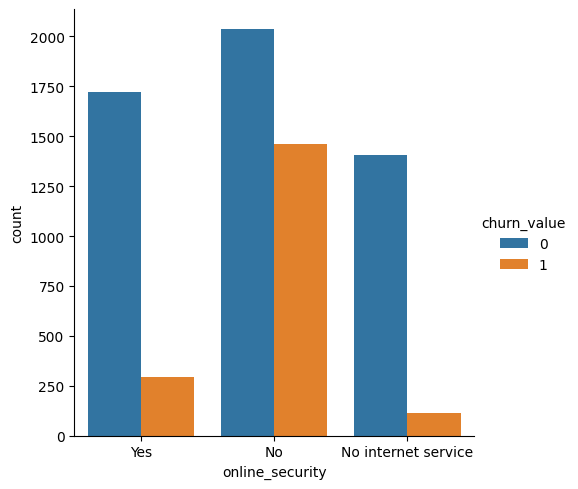

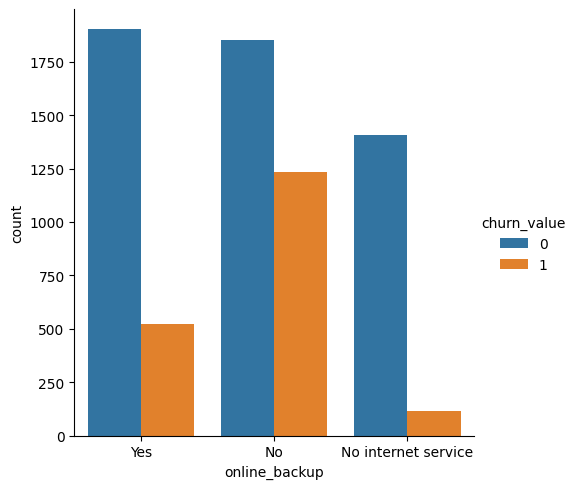

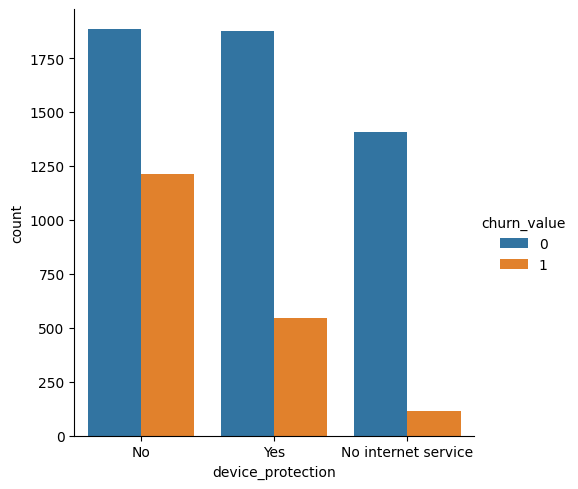

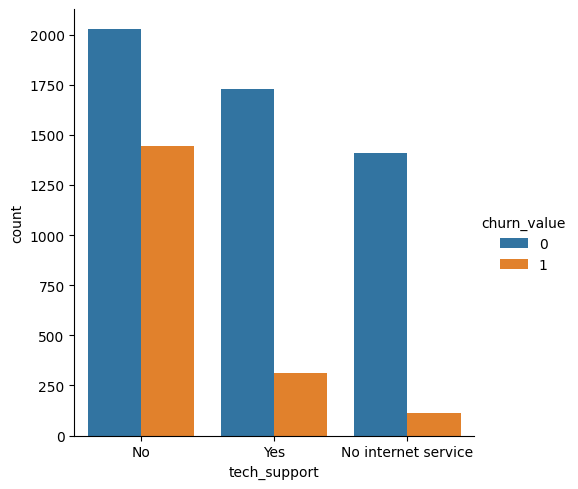

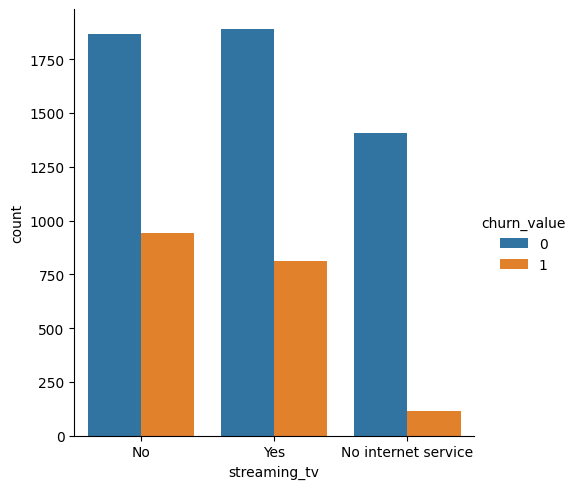

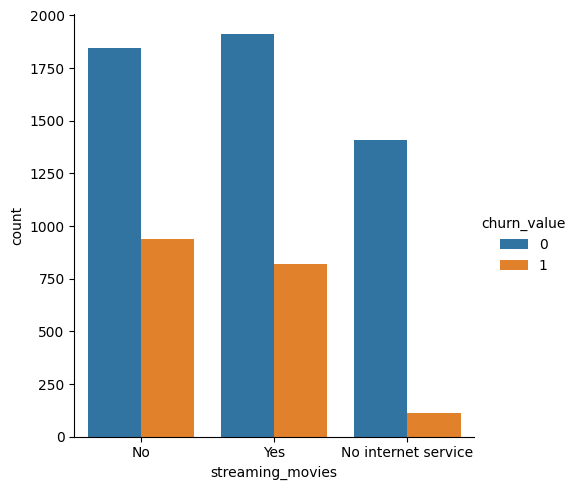

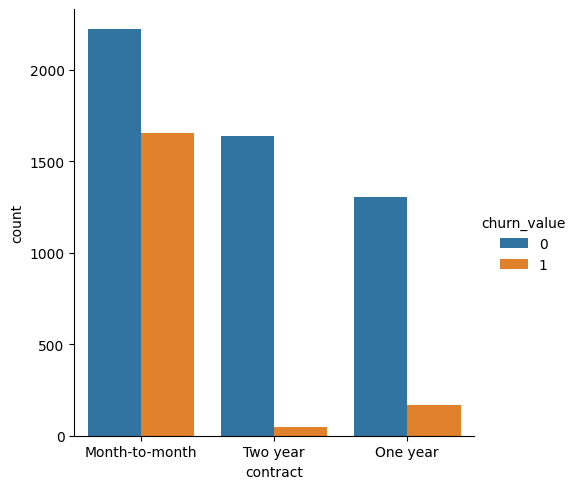

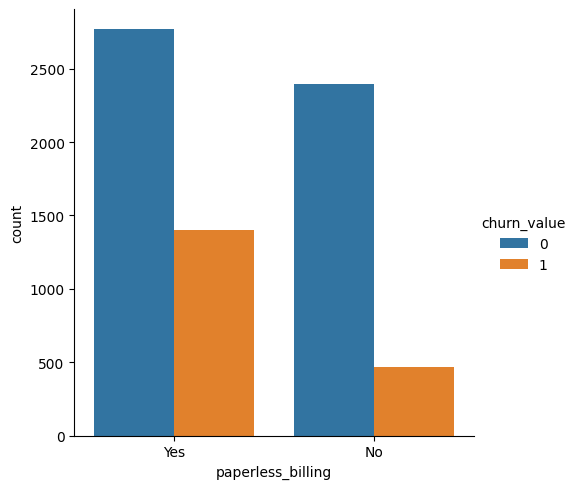

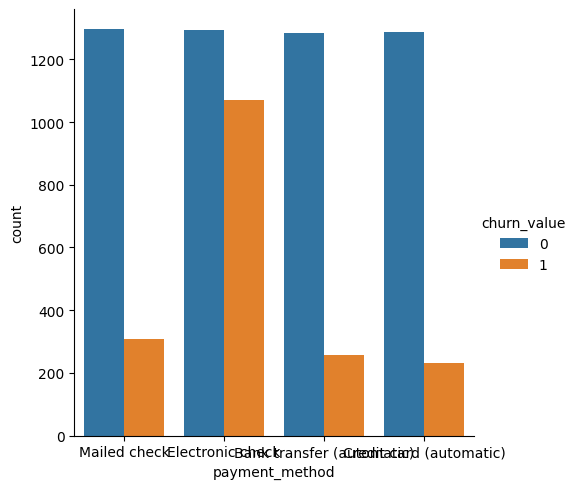

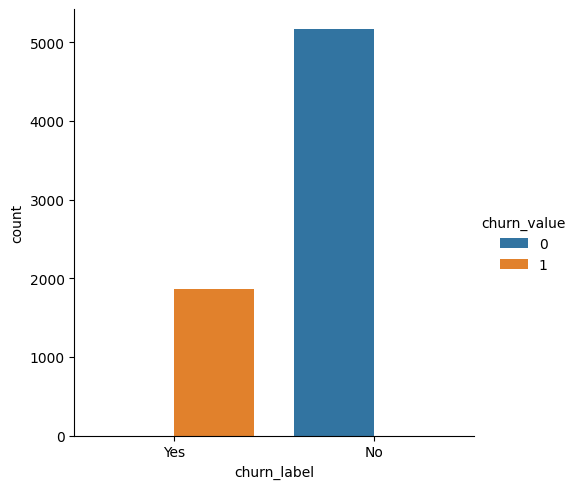

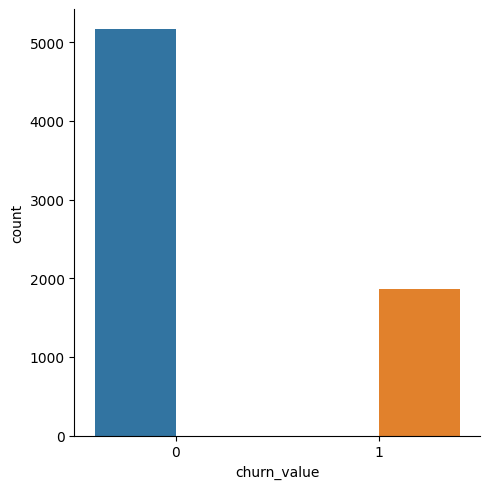

In [254]:
for feature in categorical_features:
    ax = sns.catplot(x=feature, hue='churn_value', kind="count", data=df)

Here we have compared the absolute counts. However, the relative numbers will give a better picture

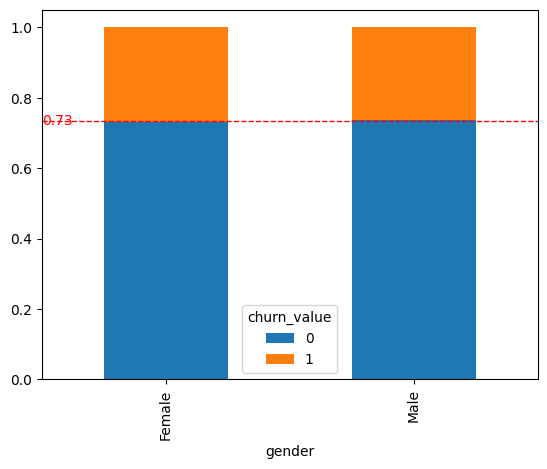

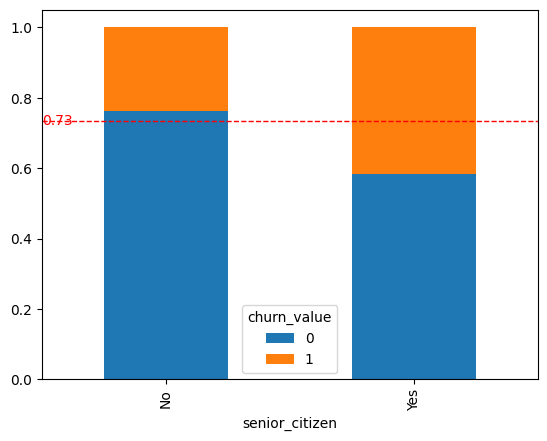

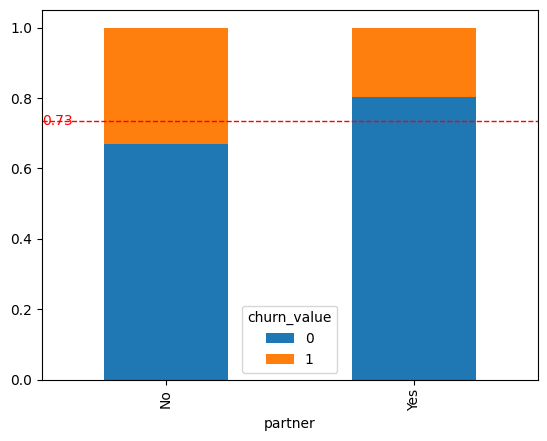

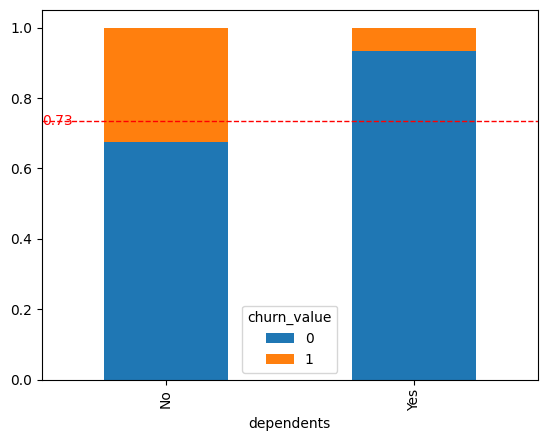

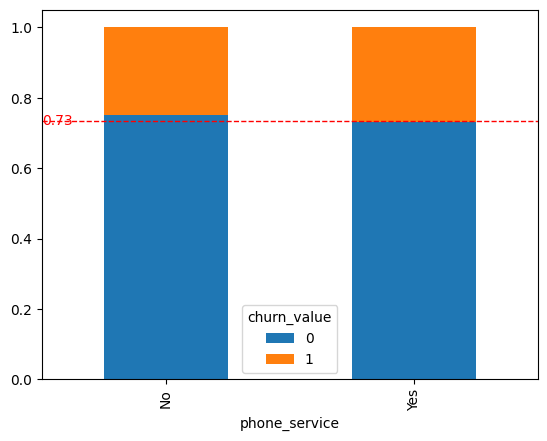

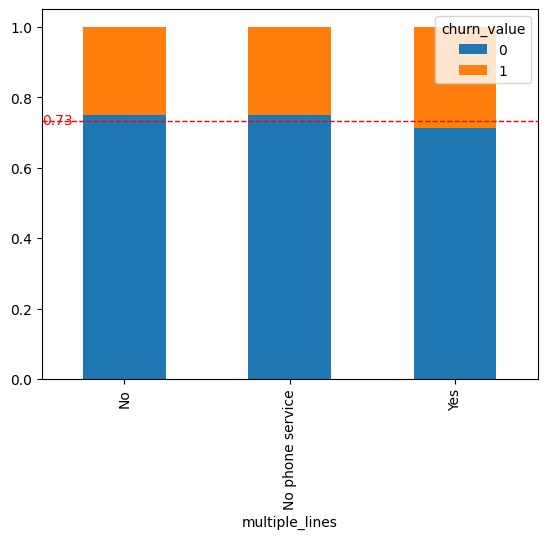

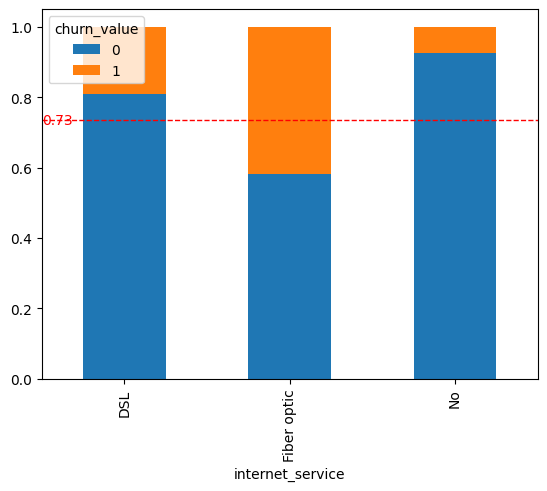

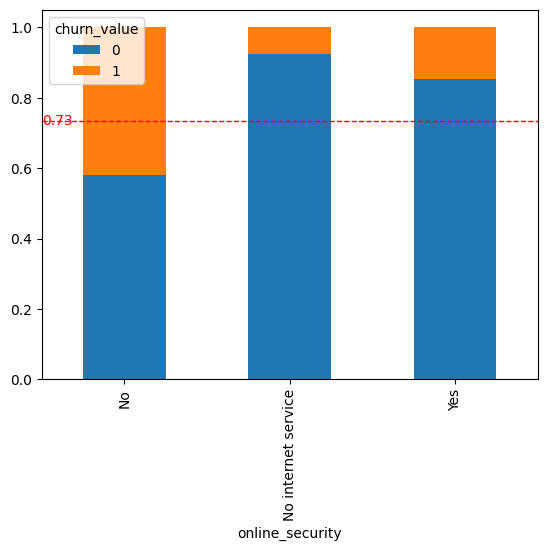

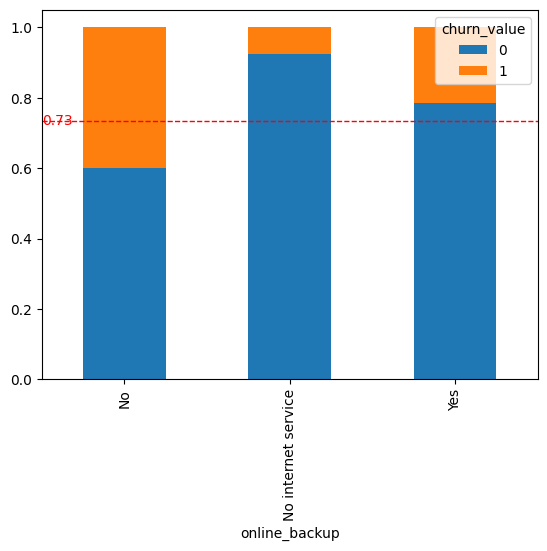

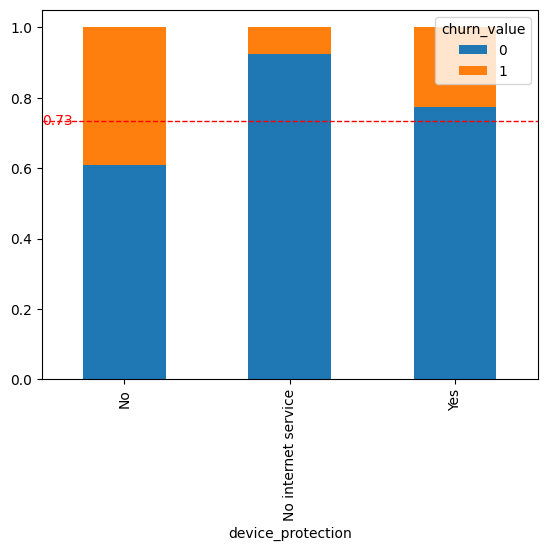

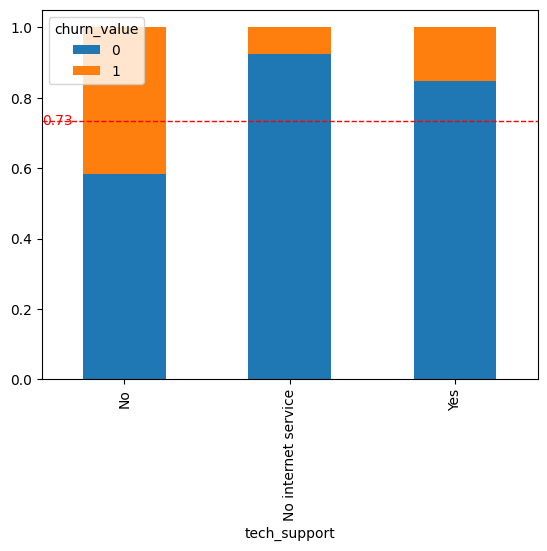

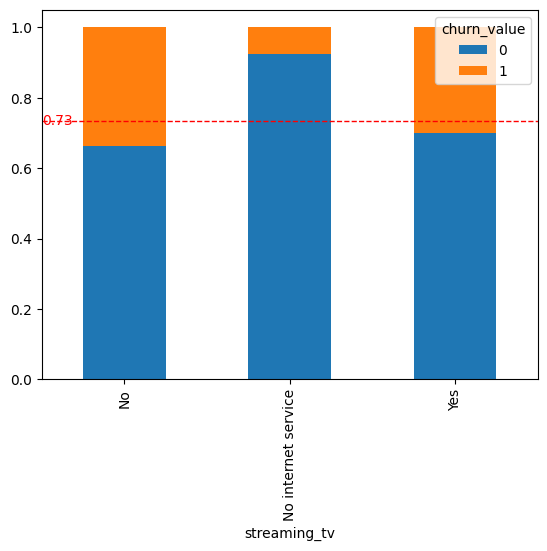

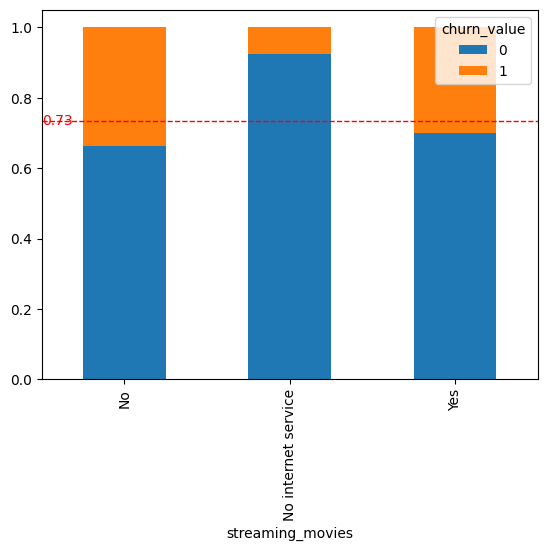

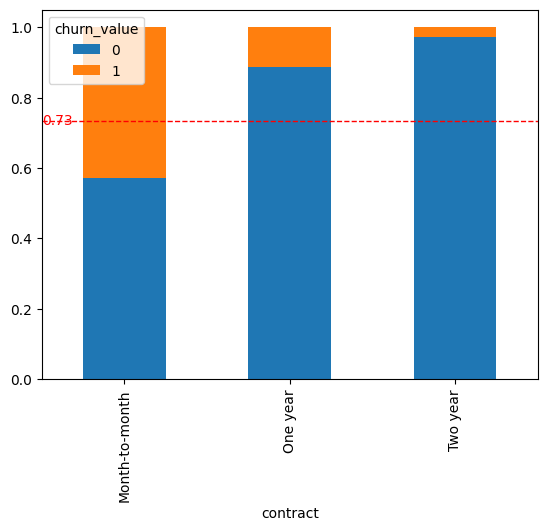

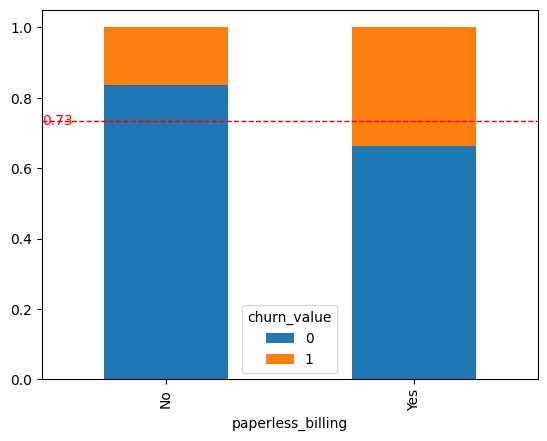

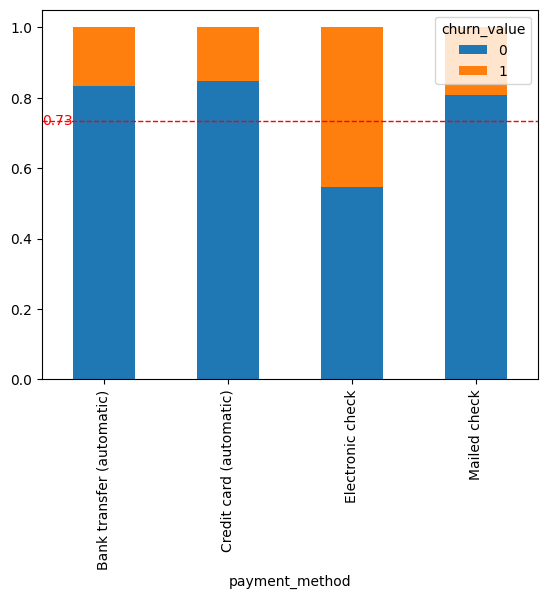

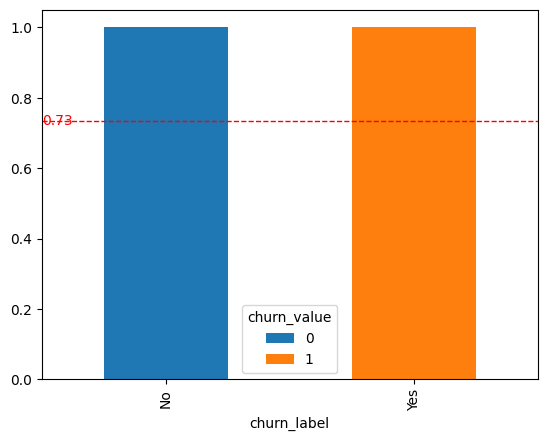

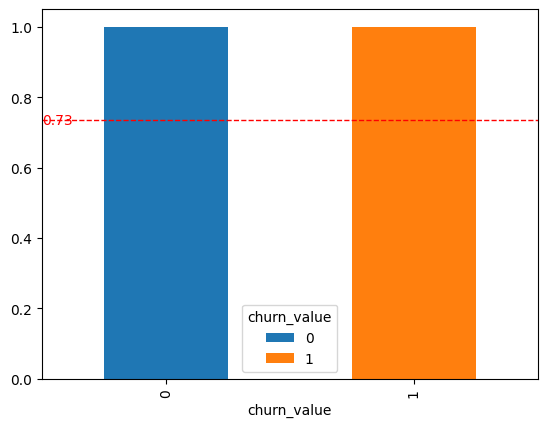

In [262]:
for feature in categorical_features:
    relative_distribution = df.groupby(feature)['churn_value'].value_counts(normalize=True).unstack()
    relative_distribution.plot(kind='bar', stacked=True)
    overall_distribution = df['churn_value'].value_counts(normalize=True)
    for value, percent in overall_distribution.items():
        plt.axhline(y=percent, color='r', linestyle='--', linewidth=1)
        plt.text(x=-0.5, y=percent, s=f'{percent:.2f}', color='r', verticalalignment='center')
        break

### Insights from bivariate analysis of categorical features:
1. Gender does not have a significant effect on churn rate
2. Senior citizens have higher churn rates as compared to other citizens
3. Customers with partner/dependants have lower churn rates
4. Customers using fiber optic have higher churn rates
5. Customers not having internet service have lower churn rates
6. Customers opting for longer plans have lower churn rates

## Comparing correlation among features
In this section, we try to analyze the correlations among features
1. For categorical features: We use chi square test
2. For numerical features we use Pearson's correlation test

<AxesSubplot: >

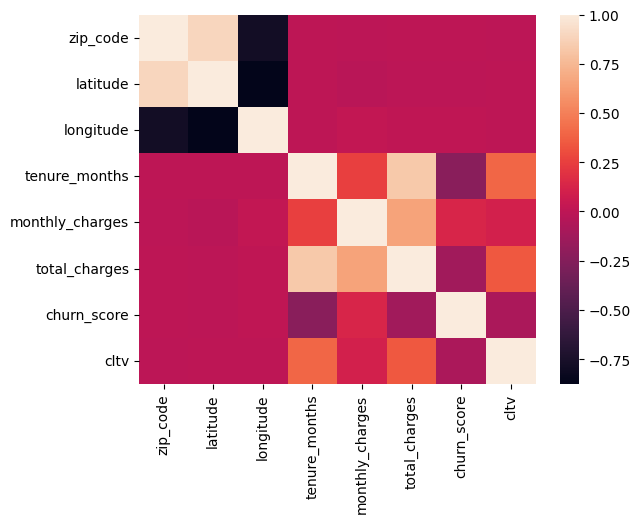

In [265]:
sns.heatmap(df[numerical_features].corr())

<AxesSubplot: >

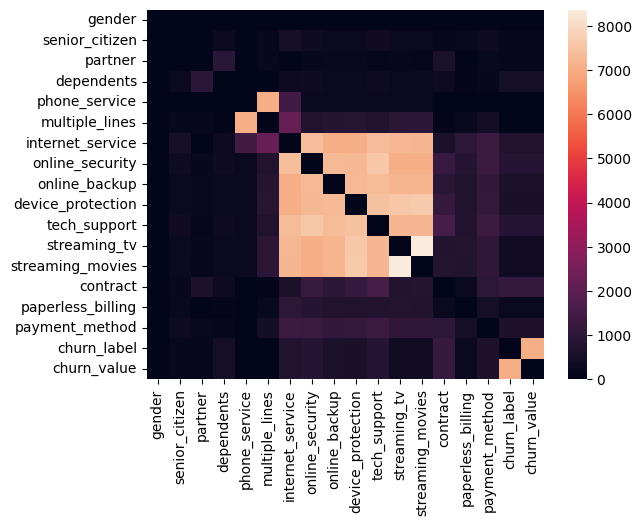

In [268]:
def chi_square_matrix(df, features):
    df = df[features]
    chi2_matrix = pd.DataFrame(index=features, columns=features)
    
    for feature1 in features:
        for feature2 in features:
            if feature1 == feature2:
                chi2_matrix.loc[feature1, feature2] = 0
            else:
                contingency_table = pd.crosstab(df[feature1], df[feature2])
                chi2, p, dof, ex = chi2_contingency(contingency_table)
                chi2_matrix.loc[feature1, feature2] = chi2    
    return chi2_matrix.astype(float)

sns.heatmap(chi_square_matrix(df, categorical_features))

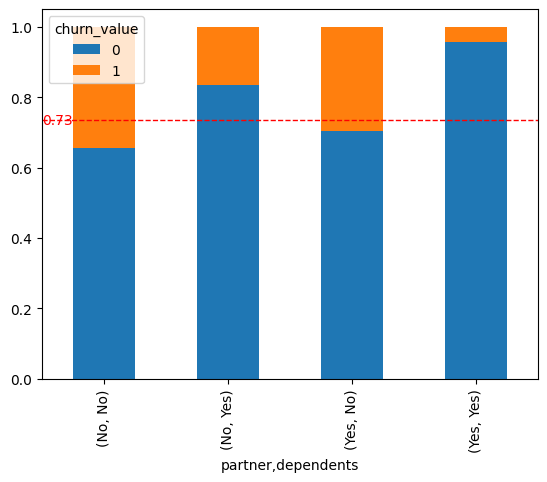

In [274]:
relative_distribution = df.groupby(["partner", "dependents"])['churn_value'].value_counts(normalize=True).unstack()
relative_distribution.plot(kind='bar', stacked=True)
overall_distribution = df['churn_value'].value_counts(normalize=True)
for value, percent in overall_distribution.items():
    plt.axhline(y=percent, color='r', linestyle='--', linewidth=1)
    plt.text(x=-0.5, y=percent, s=f'{percent:.2f}', color='r', verticalalignment='center')
    break